In [3]:
import lmfit as lm
import numpy as np
import xarray as xr

Say we want to calculate the kinetic energy and we have measurements:

m = 5(1) kg

v = 10(2) m/s

Let's calculate the error by Monte Carlo error propagation. In this case we could also have calculated the error analytically, but in more complicated scenario's a method like Monte Carlo is the only reasonable approach.

In [4]:
def kinetic_energy_J(m_kg, v_mps):
    return 0.5 * m_kg * v_mps**2

Lets start again using `xarray`.

In [6]:
ds = xr.Dataset()
ds["v_mps"] = 5
ds.v_mps.attrs = {"long_name": "Velocity", "units": "m/s"}
ds["m_kg"] = 10
ds.m_kg.attrs = {"long_name": "Mass", "units": "kg"}
ds["Ekin_J"] = xr.apply_ufunc(kinetic_energy_J, ds.m_kg, ds.v_mps)
ds.Ekin_J.attrs = {"long_name": "Energy", "units": "J"}
ds

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    v_mps    int64 8B 5
    m_kg     int64 8B 10
    Ekin_J   float64 8B 125.0

So the value of the kinetic energy is 125 J, but what about the error?

Let's sample from the distribution of m and v and calculate for each realization the kinetic energy, this should give us then the distribution of values for the kinetic energy for the variability in v and m.

In [7]:
v_mps_mean = 5
v_mps_std = 1
m_kg_mean = 10
m_kg_std = 2
mc_size = 10000
ds = xr.Dataset()
ds["v_mps"] = xr.DataArray(np.random.normal(v_mps_mean, v_mps_std, mc_size), dims='mc')
ds.v_mps.attrs = {"long_name": "Velocity", "units": "m/s"}
ds["m_kg"] = xr.DataArray(np.random.normal(m_kg_mean, m_kg_std, mc_size), dims='mc')
ds.m_kg.attrs = {"long_name": "Mass", "units": "kg"}
ds["Ekin_J"] = xr.apply_ufunc(kinetic_energy_J, ds.m_kg, ds.v_mps)
ds.Ekin_J.attrs = {"long_name": "Energy", "units": "J"}
ds

<xarray.Dataset> Size: 240kB
Dimensions:  (mc: 10000)
Dimensions without coordinates: mc
Data variables:
    v_mps    (mc) float64 80kB 3.873 4.812 4.994 6.144 ... 4.268 4.422 4.811
    m_kg     (mc) float64 80kB 9.769 10.13 11.68 9.609 ... 9.353 9.059 8.51
    Ekin_J   (mc) float64 80kB 73.28 117.3 145.7 181.4 ... 85.19 88.55 98.48

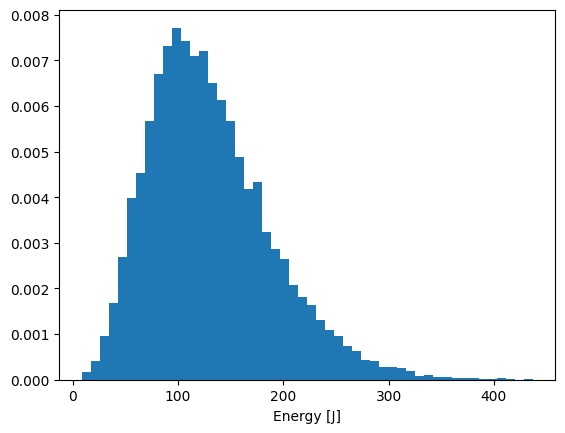

In [8]:
ds.Ekin_J.plot.hist(bins=50, density=True);

From this distribution we can calculate the mean and standard deviation for the kinetic energy.

In [11]:
Ekin_J_mean = ds.Ekin_J.mean('mc')
Ekin_J_std = ds.Ekin_J.std('mc')
print(f"E_kin = {Ekin_J_mean:.1f} +- {Ekin_J_std:.1f} J")

E_kin = 130.7 +- 58.5 J


Let's now plot the extracted distribution over the Monte Carlo results and compare the two.

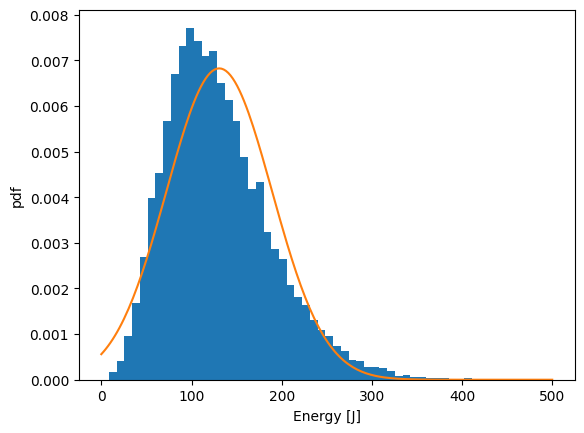

In [10]:
ds_fit = xr.Dataset()
ds_fit['Ekin'] = np.linspace(0, 500, 200)
ds_fit.Ekin.attrs = {"long_name": "Energy", "units": "J"}

ds_fit['pdf'] = xr.DataArray(lm.models.GaussianModel().eval(x=ds_fit.Ekin, center = Ekin_J_mean, sigma = Ekin_J_std), dims='Ekin')

ds.Ekin_J.plot.hist(bins=50, density=True);
ds_fit.pdf.plot()

We can see that the non-linear scaling with the velocity has resulted in a skewed distribution. Giving rise to a different mean of around 131 J compared to the 125 J calcuated from the means of the mass and velocity.